#### a2  
a2 are basically the same as a1  
the only difference is that the input length become longer  

In [1]:
import os
import torch as tc
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
from data_set_.data_loader_ import ISITDataset, make_df_from_data_dir
from nets.nn_net_b import NeuralNetwork_b
from torch.optim.lr_scheduler import CosineAnnealingLR

some utils function

In [2]:
def to_devices(varlist,device):
  ret_list = []
  for  vari in varlist:
    ret_list.append(vari.to(device))
  return ret_list
def mul_zeros_likes(varlist):
  ret_list = []
  for  vari in varlist:
    ret_list.append(tc.zeros_like(vari))
  return ret_list
def plot_accu(x,y,title,
    suptitile= "Unimodal Classification",
    xlabel='number of events to detection',
    ylabel='probability of correct classification',
    ):
  fig, ax = plt.subplots(1,1,figsize=(5,5))
  fig.suptitle(suptitile, fontsize=16)
  ax.set_title(title,fontsize=12)
  ax.set_ylabel(ylabel,fontsize =12)
  ax.set_xlabel(xlabel,fontsize =12)
  ax.set_ylim([0, 1])
  plt.yticks(np.arange(0, 1+0.05, 0.05))
  plt.grid(True)
  ax.scatter(x,y)
  plt.tight_layout() 
  plt.show()
  return


### configuration

In [3]:
# Device configuration
device = tc.device("cuda" if tc.cuda.is_available() else "cpu")
# Load and preprocess data
train_data_ratio = 0.8
df_dict_all, df_dict_train, df_dict_eval = make_df_from_data_dir(train_data_ratio=train_data_ratio)
# Hyperparameters
max_sample_len_train = 70
min_sample_len_train = 1
max_sample_len_eval = 70
training_len = 100  #* 500  
eval_len = 600
bs = 128
bs_eval = 1
learning_rate = 0.002
# Load from checkpoint if available
ckpt_path = 'model_a2.ckpt'
load_from_checkpoint = os.path.isfile(ckpt_path)
if not os.path.isfile(ckpt_path):
  print("cant find file ckpt path, train from scratch")
  load_from_checkpoint = False

./data/isit-2024-bits-and-bots/ISIT_Dataset/hlisa_traces
./data/isit-2024-bits-and-bots/ISIT_Dataset/gremlins
./data/isit-2024-bits-and-bots/ISIT_Dataset/za_proxy
./data/isit-2024-bits-and-bots/ISIT_Dataset/survey_desktop
./data/isit-2024-bits-and-bots/ISIT_Dataset/random_mouse_with_sleep_bot
hlisa_traces
gremlins
za_proxy
survey_desktop
random_mouse_with_sleep_bot
hlisa_traces Index(['userId', 'x', 'y', 'eventName', 'userType', 'time_diff'], dtype='object') 398788
unique user 1166 / 398788
gremlins Index(['userId', 'x', 'y', 'eventName', 'userType', 'time_diff'], dtype='object') 185657
unique user 577 / 185657
za_proxy Index(['userId', 'x', 'y', 'eventName', 'userType', 'time_diff'], dtype='object') 46426
unique user 853 / 46426
survey_desktop Index(['userId', 'x', 'y', 'eventName', 'userType', 'time_diff'], dtype='object') 650641
unique user 64743 / 650641
random_mouse_with_sleep_bot Index(['userId', 'x', 'y', 'eventName', 'userType', 'time_diff'], dtype='object') 183365
unique user 

Prepare datasets and dataloaders

In [4]:
# Prepare datasets and dataloaders
train_dataset = ISITDataset(df_dict_train, training_len=training_len*bs,
                            min_sample_len=min_sample_len_train,
                            max_sample_len=max_sample_len_train)
eval_dataset = ISITDataset(df_dict_eval, training_len=eval_len*bs_eval,
                           min_sample_len=max_sample_len_eval,
                           max_sample_len=max_sample_len_eval)
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=12, pin_memory=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=bs_eval, shuffle=True, num_workers=12, pin_memory=True)


#### model  
7 layer mlp  

In [5]:
class NeuralNetwork_b(nn.Module):
  def __init__(self,max_len,output_size):
    super().__init__()
    self.max_len = max_len   #70 = 210
    self.flatten = nn.Flatten()
    neural_size = 512
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(max_len*4, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, output_size),
    )

  def forward(self, time_diff,pos_x,pos_y,eventName):
    '''
    time_diff (bs,max_len) = (128,70)
    pos_x (bs,max_len)
    pos_y (bs,max_len)
    terminate_idx (bs)  range 0~max_len
    '''
    bs, max_len = time_diff.shape
    time_diff2 = time_diff.unsqueeze(-1)
    pos_x2 = pos_x.unsqueeze(-1)
    pos_y2 = pos_y.unsqueeze(-1)
    eventName2 = eventName.unsqueeze(-1)
    xxx = tc.cat((time_diff2,pos_x2,pos_y2,eventName2),dim=2)
    # breakpoint()
    xx = xxx.reshape(bs,-1)
    # print(time_diff[tc.arange(bs),terminate_idx-1])
    logits = self.linear_relu_stack(xx)
    return logits  #(bs,user_type)  user_type is 0,1,..4

#### start training  

In [6]:

# Model, loss function, optimizer, and scheduler
category = len(train_dataset.idx_2_name)  # 5 categories
model = NeuralNetwork_b(max_len=max_sample_len_train, output_size=category).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = tc.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-3)
# Load model from checkpoint if available
if load_from_checkpoint:
  checkpoint = tc.load(ckpt_path)
  model.load_state_dict(checkpoint['state_dict'])
else:
  for epoch in range(training_len):
    model.train()
    for batch in train_dataloader:
      _, td, px, py, eventName, _, userType = batch  #* td: time_diff, px: pos_x, py: pos_y
      td,px,py,userType,eventName = to_devices([td,px,py,userType,eventName],device)
      optimizer.zero_grad()
      y_hat = model(td,px,py,eventName)
      loss = criterion(y_hat, userType)
      loss.backward()
      optimizer.step()
    scheduler.step()
    print(f"Epoch [{epoch + 1}/{training_len}], Loss: {loss.item()}")

  tc.save({'state_dict': model.state_dict()}, ckpt_path)


Epoch [1/100], Loss: 0.8549348711967468
Epoch [2/100], Loss: 0.49693551659584045
Epoch [3/100], Loss: 0.6180214285850525
Epoch [4/100], Loss: 0.43382367491722107
Epoch [5/100], Loss: 0.3620772957801819
Epoch [6/100], Loss: 0.42399007081985474
Epoch [7/100], Loss: 0.3052550256252289
Epoch [8/100], Loss: 0.5018006563186646
Epoch [9/100], Loss: 0.2555316090583801
Epoch [10/100], Loss: 0.3442513048648834
Epoch [11/100], Loss: 0.2629302740097046
Epoch [12/100], Loss: 0.3095301389694214
Epoch [13/100], Loss: 0.2674711048603058
Epoch [14/100], Loss: 0.25985345244407654
Epoch [15/100], Loss: 0.28138184547424316
Epoch [16/100], Loss: 0.4265737533569336
Epoch [17/100], Loss: 0.20742875337600708
Epoch [18/100], Loss: 0.2280270755290985
Epoch [19/100], Loss: 0.15578611195087433
Epoch [20/100], Loss: 0.3514045476913452
Epoch [21/100], Loss: 0.3505087196826935
Epoch [22/100], Loss: 0.2655993402004242
Epoch [23/100], Loss: 0.24412015080451965
Epoch [24/100], Loss: 0.2653130888938904
Epoch [25/100], L

### Evaluation

In [7]:
model.eval()
thres_num = 10
conf_thres_list = np.linspace(0, 1, thres_num + 1)[1:-1]
tot_num_correct = 0
tot_num_samples = 0
tot_num_false_positives = 0
tot_num_false_negatives = 0
tot_num_HLISA_correct = 0
tot_num_HLISA_samples = 0
n_to_detect_list = np.zeros(len(conf_thres_list))
conf_n_correct_list = np.zeros(len(conf_thres_list))
conf_tot_n_samples_list = np.zeros(len(conf_thres_list))
conf_false_positives_list = np.zeros(len(conf_thres_list))
conf_false_negatives_list = np.zeros(len(conf_thres_list))
conf_HLISA_correct_list = np.zeros(len(conf_thres_list))
conf_HLISA_samples_list = np.zeros(len(conf_thres_list))

with tc.no_grad():
  for batch in eval_dataloader:
    _, td, px, py, eventName,_, userType = batch
    td,px,py,userType,eventName = to_devices([td,px,py,userType,eventName],device)
    for conf_i, conf_thres in enumerate(conf_thres_list):
      max_conf = 0
      n_to_detect = 0
      px2,py2,td2,eventName2 = mul_zeros_likes([px,py,td,eventName])
      while n_to_detect < max_sample_len_eval and max_conf < conf_thres:
        px2[0, n_to_detect] = px[0, n_to_detect]
        py2[0, n_to_detect] = py[0, n_to_detect]
        td2[0, n_to_detect] = td[0, n_to_detect]
        eventName2[0,n_to_detect] = eventName[0,n_to_detect]
        y_hat = model(td2,px2,py2,eventName2)
        conf_y_hat = tc.softmax(y_hat, dim=1)
        max_conf = conf_y_hat.max(dim=1)[0]
        n_to_detect += 1

      _, predictions = y_hat.max(1)
      n_correct = (predictions == userType).sum().item()
      n_sample = predictions.size(0)

      # Calculate false positives (human misclassified as bot)
      false_positives = ((predictions != userType) & (userType == 3)).sum().item()  # userType 3 corresponds to human
      # Calculate false negatives (bot misclassified as human)
      false_negatives = ((predictions != userType) & (userType != 3)).sum().item()  # userType 3 corresponds to human
      # Calculate HLISA detection rate
      HLISA_correct = ((predictions == userType) & (userType == 0)).sum().item()  # userType 0 corresponds to HLISA
      HLISA_samples = (userType == 0).sum().item()  # userType 0 corresponds to HLISA

      n_to_detect_list[conf_i] += n_to_detect
      conf_n_correct_list[conf_i] += n_correct
      conf_tot_n_samples_list[conf_i] += n_sample
      conf_false_positives_list[conf_i] += false_positives
      conf_false_negatives_list[conf_i] += false_negatives
      conf_HLISA_correct_list[conf_i] += HLISA_correct
      conf_HLISA_samples_list[conf_i] += HLISA_samples

      tot_num_correct += n_correct
      tot_num_samples += n_sample
      tot_num_false_positives += false_positives
      tot_num_false_negatives += false_negatives
      tot_num_HLISA_correct += HLISA_correct
      tot_num_HLISA_samples += HLISA_samples
print(f"Accuracy on test set: {tot_num_correct / tot_num_samples * 100:.2f}%")
# Calculate metrics
accuracy_list = conf_n_correct_list / conf_tot_n_samples_list
false_positive_rate_list = conf_false_positives_list / conf_tot_n_samples_list
false_negative_rate_list = conf_false_negatives_list / conf_tot_n_samples_list
HLISA_detection_rate_list = conf_HLISA_correct_list / conf_HLISA_samples_list

avg_n_to_detect_list = n_to_detect_list / eval_len
#from utils import plot_threshold;   plot_threshold(title,conf_thres_list,n_to_detect_list,accu_list)
avg_length = np.mean(n_to_detect_list)
print("Average number of events to detection:", avg_length)


Accuracy on test set: 78.57%
Average number of events to detection: 1513.888888888889


### Visualization

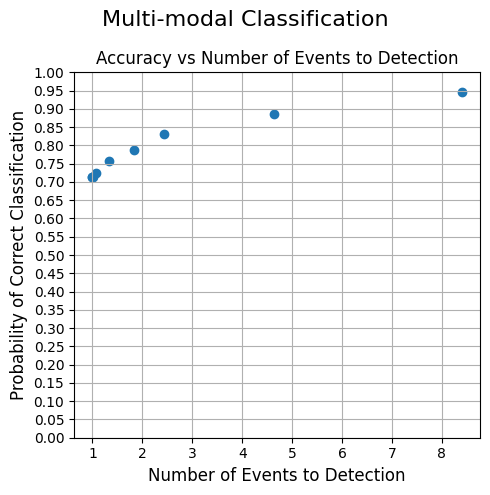

In [8]:
suptitle = "Multi-modal Classification"
title = "Accuracy vs Number of Events to Detection"
plot_accu(avg_n_to_detect_list , accuracy_list, title,
          suptitile=suptitle,
          xlabel='Number of Events to Detection',
          ylabel='Probability of Correct Classification')


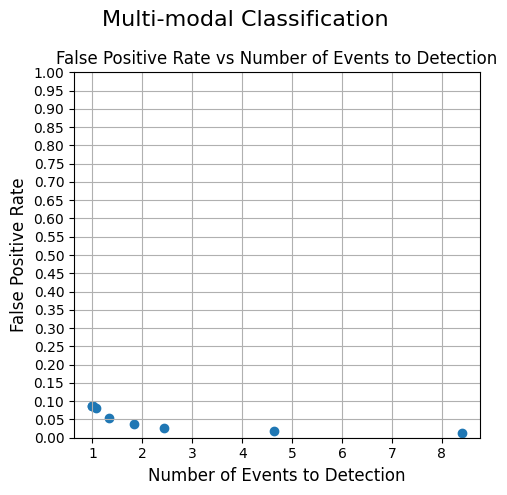

In [9]:
title = "False Positive Rate vs Number of Events to Detection"
plot_accu(avg_n_to_detect_list , false_positive_rate_list, title,
          suptitile=suptitle,
          xlabel='Number of Events to Detection',
          ylabel='False Positive Rate')

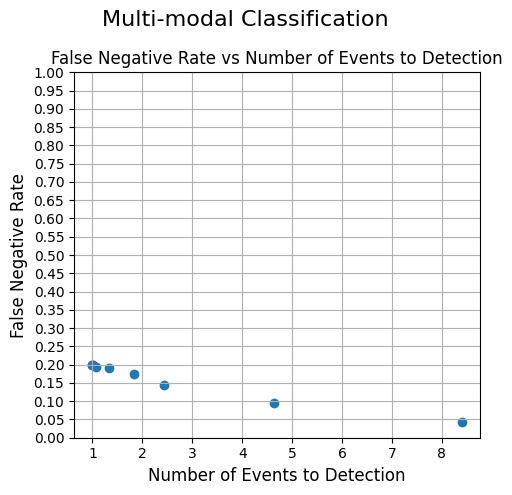

In [10]:
title = "False Negative Rate vs Number of Events to Detection"
plot_accu(avg_n_to_detect_list , false_negative_rate_list, title,
          suptitile=suptitle,
          xlabel='Number of Events to Detection',
          ylabel='False Negative Rate')

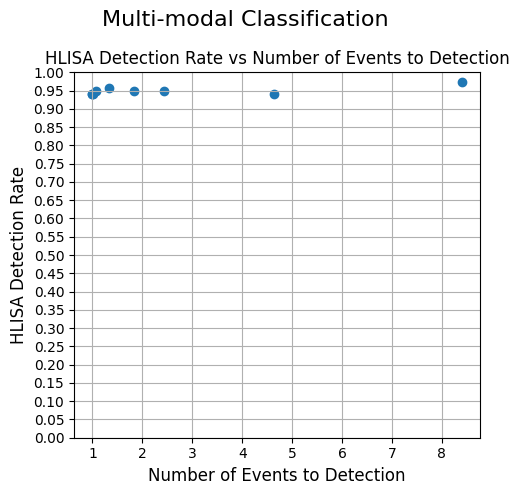

In [11]:
title = "HLISA Detection Rate vs Number of Events to Detection"
plot_accu(avg_n_to_detect_list , HLISA_detection_rate_list,  title,
          suptitile=suptitle,
          xlabel='Number of Events to Detection',
          ylabel='HLISA Detection Rate')
